## Import libraries

In [2]:
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import os 
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, MaxPooling2D
from keras.preprocessing import image as kimage
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


## Image Acquisition

In [3]:
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [4]:
base_path = '/Users/raffaeleanselmo/Desktop/Università/Digital Signal and Image Processing/project/images/'
train_path = [os.path.join(base_path+'TRAINING',img) for img in os.listdir(base_path)]
test_path = [os.path.join(base_path+'TEST',img) for img in os.listdir(base_path)]

In [10]:
i = 0
for i in range(300):
    # Collegamento al primo dispositivo di tipo video
    cap = cv.VideoCapture(0)
    # Acquisizione immagine
    result, img = cap.read()
    
    faces = face_detector.detectMultiScale(img)
    #faces = faces.tolist()

    for (x,y,w,h) in faces:
            face = img[y:y+h,x:x+h,:]
            face = cv.cvtColor(face, cv.COLOR_BGR2GRAY)
            
    cv.imwrite(base_path+'TRAINING/2/image{:>03}.jpeg'.format(i),face)
    i=i+1
    
# Rilascio del dispositivo
cap.release()

## Preprocessing

In [11]:
batch_size = 32

In [12]:
#Training Set data Augmentation
data_processing = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                     horizontal_flip=True,         #horizontal flip
                                     width_shift_range=0.2,        #width shifting
                                     height_shift_range=0.2,       #height shifting
                                     brightness_range = (0.4,1.5), #brightness shifting
                                     zoom_range = [0.5,1.0],       #Random Zoom
                                     #channel_shift_range = 150,    #channel shifting
                                    # vertical_flip = True,          #Vertical flip
                                     rotation_range=90
                                     )
train_generator = data_processing.flow_from_directory(
        directory=base_path+'TRAINING/',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 892 images belonging to 3 classes.


In [13]:
#Test Set data generation
test_processing = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_processing.flow_from_directory(
        directory=base_path+'TEST',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
)

Found 82 images belonging to 3 classes.


## VGG16 Fine Tuning

In [14]:
#Modello di base
base_net = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [15]:
#Creazione di un dizionario che mappi i layer ai loro nomi
layer_dict = dict([(layer.name, layer) for layer in base_net.layers])

In [16]:
#Congelamento del modello di base
for layer in base_net.layers:
    layer.trainable = False

In [17]:
#Output del modello di base
x = base_net.output
#Nuovo livello fully-connected intermedio + ReLU
x = Dense(256, activation='relu')(x)
#Nuovo livello di Dropout
x = Dropout(0.3)(x)
#Nuovo livello fully-connected intermedio + ReLU
x = Dense(128, activation='relu')(x)
#Nuovo livello di Dropout
x = Dropout(0.2)(x)
#Nuovo livello fully-connected finale + softmax
pred = Dense(3, activation='softmax')(x)

In [18]:
#Modello specializzato
net = Model(inputs=base_net.input, outputs=pred)

In [19]:
#Compilazione del modello per l'addestramento
net.compile(loss=keras.losses.binary_crossentropy,
            optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [20]:
epochs = 5
steps_per_epoch = 10

In [21]:
history = net.fit_generator(train_generator, 
                            epochs=epochs,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=test_generator)

Epoch 1/5
10/10 [==============================] - 124s 12s/step - loss: 0.8892 - accuracy: 0.6854 - val_loss: 0.3869 - val_accuracy: 0.6138
Epoch 2/5
10/10 [==============================] - 123s 12s/step - loss: 0.2719 - accuracy: 0.8771 - val_loss: 0.5282 - val_accuracy: 0.7480
Epoch 3/5
10/10 [==============================] - 123s 12s/step - loss: 0.1441 - accuracy: 0.9504 - val_loss: 0.3063 - val_accuracy: 0.8984
Epoch 4/5
10/10 [==============================] - 125s 12s/step - loss: 0.1264 - accuracy: 0.9552 - val_loss: 0.5604 - val_accuracy: 0.7317
Epoch 5/5
10/10 [==============================] - 123s 12s/step - loss: 0.0729 - accuracy: 0.9736 - val_loss: 0.2944 - val_accuracy: 0.8577


In [22]:
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 
             color=colors[0],
             label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.2,1])
    else:
      plt.ylim([0,1])

    plt.legend()

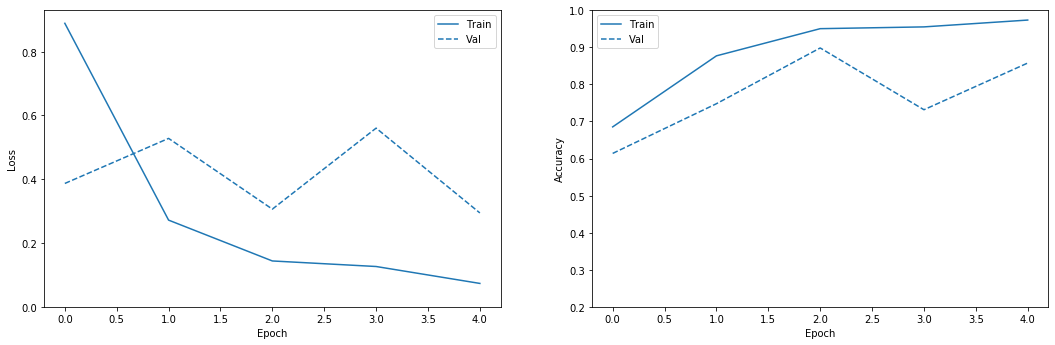

In [23]:
plot_metrics(history)

In [24]:
net.save("model.h5")

In [25]:
net = keras.models.load_model('model.h5')

In [27]:
nomi = ['Enzo Dio porco' ,'Raf Dio cane', "Iacopo gesu gay"]

## Demo

In [32]:
def process_frame(img):
    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    color = (255,0,0)
    face = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    faces = face_detector.detectMultiScale(gray, minNeighbors=7)
     
    for (x,y,w,h) in faces:
        cv.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
        face = img[y:y+h,x:x+w]
        face = cv.cvtColor(face, cv.COLOR_BGR2RGB)

        img_pixels = cv.resize(face, (224, 224)) 
        img_pixels = img_to_array(img_pixels)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels = preprocess_input(img_pixels)
        y_dist = net.predict(img_pixels)
        y_pred = np.argmax(y_dist)
        y_dist = y_dist[0, y_pred]

        if(y_dist > 0.75):
            index = nomi[y_pred]
        else:
            index = "madonna troia"

        cv.putText(img,
                  (str(index)+''+str(y_dist)),
                  (x+5,y+5),
                  cv.FONT_HERSHEY_SIMPLEX,
                  1,
                  color,
                  2)
                    
    return img, face

In [34]:
cap = cv.VideoCapture(0)

while(True):
    r, frame = cap.read()
    faces, gray= process_frame(frame)
    cv.imshow('Video', frame)
    key = cv.waitKey(20) & 0xFF
    if key == ord("q"):
        break
        
cap.release()
cv.destroyAllWindows()


## Test statico di validazione 

In [86]:
cap = cv.VideoCapture(0)
# Acquisizione immagine
result, img = cap.read()
# Rilascio del dispositivo
cap.release()

In [87]:
faces = face_detector.detectMultiScale(img)
#faces = faces.tolist()

for (x,y,w,h) in faces:
        face = img[y:y+h,x:x+h,:]
        face = cv.cvtColor(face, cv.COLOR_BGR2RGB)

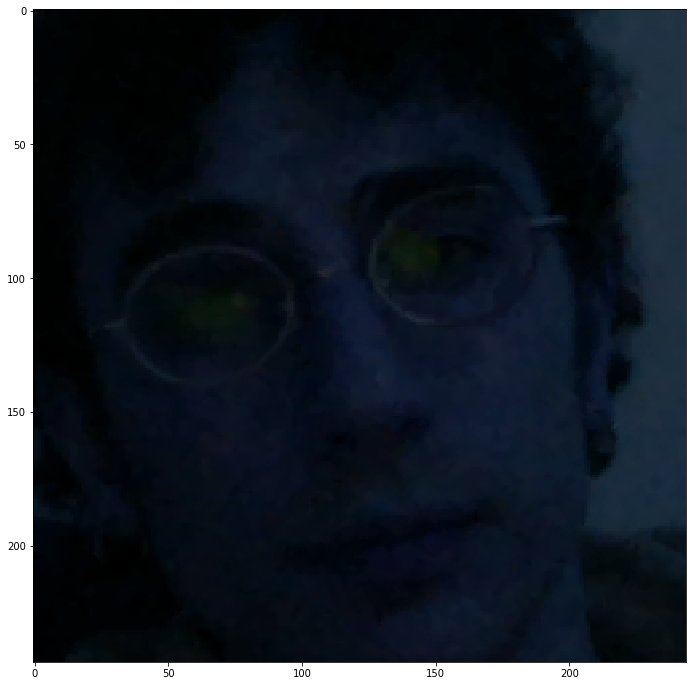

(<matplotlib.image.AxesImage at 0x1ab3a21810>, None)

In [88]:
plt.imshow(face[:,:,-1::-1]), plt.show()

In [94]:
img_pixels = cv.resize(face, (224, 224)) 
img_pixels = img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels = preprocess_input(img_pixels)
y_dist = net.predict(img_pixels)
y_dist

array([[0.08645989, 0.01606793, 0.89747214]], dtype=float32)